In [1]:
import tensorflow as tf

tf.config.set_visible_devices([], 'GPU')
model = tf.keras.models.load_model("../data/models/model-16-16-3-no-mixup-full")

In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)         7

In [4]:
! ls ../data/input

sample_submission.csv
test.csv
test_soundscapes
train_metadata.csv
train_short_audio
train_soundscape_labels.csv
train_soundscapes


In [6]:
! ls ../data/input/train_soundscapes

10534_SSW_20170429.ogg
11254_COR_20190904.ogg
14473_SSW_20170701.ogg
18003_COR_20190904.ogg
20152_SSW_20170805.ogg
21767_COR_20190904.ogg
26709_SSW_20170701.ogg
26746_COR_20191004.ogg
2782_SSW_20170701.ogg
28933_SSW_20170408.ogg
31928_COR_20191004.ogg
42907_SSW_20170708.ogg
44957_COR_20190923.ogg
50878_COR_20191004.ogg
51010_SSW_20170513.ogg
54955_SSW_20170617.ogg
57610_COR_20190904.ogg
7019_COR_20190904.ogg
7843_SSW_20170325.ogg
7954_COR_20190923.ogg


In [5]:
import pandas as pd

df = pd.read_csv("../data/input/train_soundscape_labels.csv")
df.head()

,row_id,site,audio_id,seconds,birds
0,7019_COR_5,COR,7019,5,nocall
1,7019_COR_10,COR,7019,10,nocall
2,7019_COR_15,COR,7019,15,nocall
3,7019_COR_20,COR,7019,20,nocall
4,7019_COR_25,COR,7019,25,nocall


In [46]:
import librosa
import numpy as np

def reshape_square(arr, k=8):
    """Domain specific. Transform 12x50 matrix into a square matrix that's 25x25."""
    x = np.zeros((12, k * k))
    x[:, : arr.shape[1]] = arr
    return x.reshape(3, 2 * k, 2 * k).T


def cens_per_sec(sample_rate, target):
    """Ensure this value is a multiple of 2**6"""
    return (sample_rate // (target * (2 ** 6))) * (2 ** 6)

def extract_features(path, cens_sr=10):
    data, sample_rate = librosa.load(path)
    cens = librosa.feature.chroma_cens(
        data, sample_rate, hop_length=cens_per_sec(sample_rate, cens_sr)
    )
    # return 5 second slices that are reshaped appropriately
    indexes = np.array([np.arange(i, i+50) for i in range(0, cens.shape[1], 50) if i + 50 < cens.shape[1]])
    res = np.array([reshape_square(x) for x in np.transpose(cens[:, indexes], [1, 0, 2])])
    return res
    

In [47]:
cens = extract_features("../data/input/train_soundscapes/21767_COR_20190904.ogg")
cens.shape

(121, 16, 16, 3)

In [50]:
res = model.predict(cens)
res.shape

(121, 397)

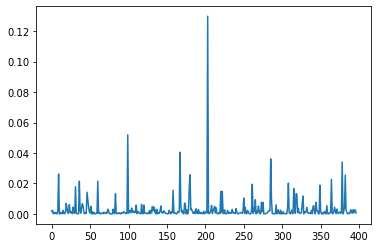

In [55]:
import matplotlib.pyplot as plt

plt.plot(res[3])

In [61]:
def predict_layer(model, data):
    feature = tf.keras.Model(
        inputs=model.input, 
        outputs=model.get_layer(index=len(model.layers)-2).output
    )
    return feature.predict(data)

res = predict_layer(model, cens)
res.shape

(121, 128)

In [86]:
data = pd.DataFrame(res)
metadata = pd.DataFrame((data.index + 1)*5, columns=["seconds"])
metadata.join(data)

,seconds,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,5,0.0,1.531111,0.184493,2.929353,0.000000,1.923335,0.185879,0.0,0.0,...,1.401089,2.290545,0.000000,1.954584,0.0,0.000000,0.0,1.208931,0.0,2.762444
1,10,0.0,1.274913,0.000000,1.116590,0.000000,2.058954,1.133968,0.0,0.0,...,1.397075,2.584254,0.000000,3.736280,0.0,0.644042,0.0,0.534271,0.0,1.886110
2,15,0.0,0.354196,0.000000,0.000000,0.000000,2.192895,0.000000,0.0,0.0,...,2.088946,3.179684,0.000000,5.994068,0.0,2.614049,0.0,0.368859,0.0,4.174380
3,20,0.0,0.353715,0.000000,0.000000,0.000000,1.817535,0.000000,0.0,0.0,...,0.310535,4.206706,0.000000,2.040344,0.0,0.511620,0.0,1.540018,0.0,3.905723
4,25,0.0,1.203756,0.000000,0.731069,0.000000,2.017058,0.803311,0.0,0.0,...,2.749487,3.636996,0.000000,3.659989,0.0,1.135114,0.0,1.936826,0.0,1.812233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,585,0.0,0.406221,0.916884,0.990605,0.000000,0.879437,1.619616,0.0,0.0,...,0.463726,0.714533,0.000000,0.000000,0.0,0.178051,0.0,0.670761,0.0,1.633652
117,590,0.0,0.301126,0.000000,1.821670,0.000000,1.361974,0.919856,0.0,0.0,...,1.073470,0.408648,0.000000,1.063406,0.0,0.000000,0.0,0.653440,0.0,1.853877
118,595,0.0,2.299230,1.090884,0.857938,0.000000,1.736746,2.116885,0.0,0.0,...,2.083942,0.000000,0.000000,0.535995,0.0,0.590799,0.0,0.475894,0.0,0.249332
119,600,0.0,2.454630,1.350345,1.275756,0.000000,1.063064,0.903857,0.0,0.0,...,1.427648,0.000000,0.376696,0.470187,0.0,0.603950,0.0,0.631261,0.0,0.883137


In [93]:
metadata["audio_id"] = 21767
metadata.head()

,seconds,audio_id
0,5,21767
1,10,21767
2,15,21767
3,20,21767
4,25,21767


In [107]:
from pathlib import Path

def extract_dataframe(model, site, audio_id, base="../data/input/train_soundscapes"):
    path = list(Path(base).glob(f"{audio_id}_{site}_*.ogg"))
    if not path:
        raise ValueError("audio not found")
    cens = extract_features(path[0])
    feature = predict_layer(model, cens)
    feature_df = pd.DataFrame(feature)
    metadata_df = pd.DataFrame((data.index + 1)*5, columns=["seconds"])
    metadata_df["site"] = site
    metadata_df["audio_id"] = audio_id
    return metadata_df.join(feature_df)

In [103]:
df.head()

,row_id,site,audio_id,seconds,birds
0,7019_COR_5,COR,7019,5,nocall
1,7019_COR_10,COR,7019,10,nocall
2,7019_COR_15,COR,7019,15,nocall
3,7019_COR_20,COR,7019,20,nocall
4,7019_COR_25,COR,7019,25,nocall


In [108]:
feature = extract_dataframe(model, "COR", 7019)
feature.head()

,seconds,site,audio_id,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
0,5,COR,7019,0.0,0.000000,0.484167,0.777650,0.0,1.760953,3.088275,...,2.594115,1.063408,0.0,0.000000,0.0,0.000000,0.0,2.170409,0.0,0.108364
1,10,COR,7019,0.0,0.000000,2.112043,0.000000,0.0,0.853193,2.591077,...,2.392371,0.063970,0.0,0.000000,0.0,0.241455,0.0,1.352149,0.0,0.840994
2,15,COR,7019,0.0,0.000000,0.877503,0.343573,0.0,0.755504,1.658037,...,3.147103,1.334816,0.0,1.016320,0.0,0.097038,0.0,0.616815,0.0,1.086201
3,20,COR,7019,0.0,0.033138,0.369459,0.181315,0.0,1.806301,2.082319,...,1.617901,0.020769,0.0,0.000000,0.0,0.504223,0.0,1.119352,0.0,1.373091
4,25,COR,7019,0.0,0.515957,0.000000,0.231343,0.0,0.303132,1.973637,...,2.322008,1.312874,0.0,1.586848,0.0,1.329830,0.0,1.241296,0.0,1.407362


In [111]:
feature.shape

(121, 131)

In [115]:
merged = df.merge(feature, on=["site", "audio_id", "seconds"])
merged

,row_id,site,audio_id,seconds,birds,0,1,2,3,4,...,118,119,120,121,122,123,124,125,126,127
0,7019_COR_5,COR,7019,5,nocall,0.0,0.000000,0.484167,0.777650,0.0,...,2.594115,1.063408,0.00000,0.000000,0.0,0.000000,0.0,2.170409,0.0,0.108364
1,7019_COR_10,COR,7019,10,nocall,0.0,0.000000,2.112043,0.000000,0.0,...,2.392371,0.063970,0.00000,0.000000,0.0,0.241455,0.0,1.352149,0.0,0.840994
2,7019_COR_15,COR,7019,15,nocall,0.0,0.000000,0.877503,0.343573,0.0,...,3.147103,1.334816,0.00000,1.016320,0.0,0.097038,0.0,0.616815,0.0,1.086201
3,7019_COR_20,COR,7019,20,nocall,0.0,0.033138,0.369459,0.181315,0.0,...,1.617901,0.020769,0.00000,0.000000,0.0,0.504223,0.0,1.119352,0.0,1.373091
4,7019_COR_25,COR,7019,25,nocall,0.0,0.515957,0.000000,0.231343,0.0,...,2.322008,1.312874,0.00000,1.586848,0.0,1.329830,0.0,1.241296,0.0,1.407362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,7019_COR_580,COR,7019,580,nocall,0.0,0.000000,0.000000,0.000000,0.0,...,3.059682,1.151402,0.29411,1.275384,0.0,0.343878,0.0,1.279578,0.0,1.789807
116,7019_COR_585,COR,7019,585,nocall,0.0,0.000000,0.000000,0.246903,0.0,...,2.204748,0.808744,0.00000,0.000000,0.0,1.710205,0.0,2.835164,0.0,0.191668
117,7019_COR_590,COR,7019,590,nocall,0.0,0.000000,0.327035,0.000000,0.0,...,3.349206,0.578086,0.00000,0.176303,0.0,0.000000,0.0,1.768299,0.0,0.784254
118,7019_COR_595,COR,7019,595,nocall,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.85220,0.000000,0.0,0.628130,0.0,1.055497,0.0,0.319721


In [128]:
# and now put it together...
import tqdm

results = []
rows = list(df[["site", "audio_id"]].drop_duplicates().itertuples())
for row in tqdm.tqdm(rows):
    results.append(extract_dataframe(model, row.site, row.audio_id))

features = pd.concat(results)
features.shape

20it [08:05, 24.28s/it]


(2420, 131)

In [132]:
res = df.merge(features, on=["site", "audio_id", "seconds"])
res

,row_id,site,audio_id,seconds,birds,0,1,2,3,4,...,118,119,120,121,122,123,124,125,126,127
0,7019_COR_5,COR,7019,5,nocall,0.0,0.000000,0.484167,0.777650,0.0,...,2.594115,1.063408,0.0,0.000000,0.0,0.000000,0.0,2.170409,0.0,0.108364
1,7019_COR_10,COR,7019,10,nocall,0.0,0.000000,2.112043,0.000000,0.0,...,2.392371,0.063970,0.0,0.000000,0.0,0.241455,0.0,1.352149,0.0,0.840994
2,7019_COR_15,COR,7019,15,nocall,0.0,0.000000,0.877503,0.343573,0.0,...,3.147103,1.334816,0.0,1.016320,0.0,0.097038,0.0,0.616815,0.0,1.086201
3,7019_COR_20,COR,7019,20,nocall,0.0,0.033138,0.369459,0.181315,0.0,...,1.617901,0.020769,0.0,0.000000,0.0,0.504223,0.0,1.119352,0.0,1.373091
4,7019_COR_25,COR,7019,25,nocall,0.0,0.515957,0.000000,0.231343,0.0,...,2.322008,1.312874,0.0,1.586848,0.0,1.329830,0.0,1.241296,0.0,1.407362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,54955_SSW_580,SSW,54955,580,nocall,0.0,2.682888,1.056530,0.000000,0.0,...,0.000000,1.021026,0.0,0.733458,0.0,3.097868,0.0,0.000000,0.0,0.000000
2396,54955_SSW_585,SSW,54955,585,grycat,0.0,0.000000,0.000000,0.930946,0.0,...,1.306528,1.262990,0.0,7.406854,0.0,3.685196,0.0,0.000000,0.0,1.638371
2397,54955_SSW_590,SSW,54955,590,grycat,0.0,1.534010,0.000000,1.047689,0.0,...,1.128624,2.651810,0.0,0.195695,0.0,0.000000,0.0,2.359753,0.0,1.986576
2398,54955_SSW_595,SSW,54955,595,nocall,0.0,0.016686,1.473288,4.940649,0.0,...,0.256271,0.000000,0.0,1.427245,0.0,0.000000,0.0,1.491268,0.0,4.137387


# appendix

In [10]:
cens.shape

(12, 6080)

In [22]:
indexes = np.array([np.arange(i, i+50) for i in range(0, cens.shape[1], 50) if i + 50 < cens.shape[1]])
indexes.shape

(121, 50)

In [35]:
x = np.transpose(cens[:, indexes], [1, 0, 2])
x.shape

(121, 12, 50)

In [42]:
res = np.array([reshape_square(g) for g in x])
res.shape

(121, 16, 16, 3)